# Part 1 - Random search 
Optimize learning rate, tau and number of hidden layers and neurons for A2C with twin critics (both for critic and critic target).

In [1]:
import HP_tuning as hp
import numpy as np
import matplotlib.pyplot as plt
import torch
from importlib import reload

In [2]:
# spans different magnitude scales, use logaritmic distribution for invariance of scale
lr_P_dict = dict(discrete=False,
                var_type='float',
                distribution='log',
                x_min = 1e-4,
                x_max = 1e-2)

# spans different magnitude scales, use logaritmic distribution for invariance of scale
tau_P_dict = dict(discrete=False,
                var_type='float',
                distribution='log',
                x_min = 1e-3,
                x_max = 1e-0)

In [3]:
possible_architectures = np.array([
                            [64,32,16],
                            [16,8,4],
                            [64,32],
                            [64,16],
                            [64,8],
                            [32,16],
                            [32,8],
                            [16,8],
                            [16,4],
                            [8,4]   
                        ])

probs = np.ones(10)/10

architecture_P_dict = dict(discrete=True,
                           var_type='str',
                           distribution='custom',
                           elements=possible_architectures,
                           p = probs)

In [4]:
P_dict = dict(lr=lr_P_dict, 
              tau=tau_P_dict,
              hiddens=architecture_P_dict)

n_samples = 15

params = {}
for key in P_dict.keys():
    P = hp.prior_distr(**P_dict[key])
    params[key] = P.sample(n_samples)
    
# now we make a list of dictionary instead of a dictionary of lists and we also add the last constant parameters
list_of_dict = []
for i in range(n_samples):
    d = {'TD' : True, 'twin' : True, 'gamma' : 0.99}
    for key in params.keys():
        d[key] = params[key][i]
    list_of_dict.append(d)

In [5]:
print("Number of combinations: ", len(list_of_dict))

def print_parameters(params):
    print("Parameters: ")
    print('='*75)
    for key in params:
        if (key == 'hiddens'):
            print(key, params[key])
        else:
            print(key, '\t', params[key])
    print('='*75)

def print_HP_score(params,score,dev):
    print_parameters(params)
    print("Score: %.4f +/- %.4f"%(score,dev))
    
flag = True #set to True to see all combinations
if flag == True:
    for params in list_of_dict:
        print()
        print_parameters(params)

Number of combinations:  15

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.00649806869559937
tau 	 0.1470406746152978
hiddens [64, 16]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.00017811810391902028
tau 	 0.016971309122848287
hiddens [64, 8]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.0010481335222045807
tau 	 0.14031468828984403
hiddens [32, 16]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.0002398327938968758
tau 	 0.051612755563448215
hiddens [16, 8, 4]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.0037409951594950734
tau 	 0.5764831430008064
hiddens [16, 4]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.0002527888379392116
tau 	 0.21127485379477898
hiddens [32, 16]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.006094990106081709
tau 	 0.5812676913867587
hiddens [16, 4]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.00014286095142678696
tau 	 0.013981027048672942
hiddens [64, 16]

Parameters: 
TD 	 Tru

In [6]:
train = False
parent_dir = "Results/HP_search/"

if train:
    save = True
    n_runs = 10
    n_episodes = 3000
    HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, list_of_dict)

    if save:
        np.save(parent_dir+"HP_scores", HP_scores)
        np.save(parent_dir+"HP_asymptotic_score", HP_asymptotic_score)
        np.save(parent_dir+"HP_asymptotic_std", HP_asymptotic_std)
        np.save(parent_dir+"list_of_dict", list_of_dict)

# Evaluation

In [7]:
HP_scores = np.load(parent_dir+"HP_scores.npy")
HP_asymptotic_score = np.load(parent_dir+"HP_asymptotic_score.npy")
HP_asymptotic_std = np.load(parent_dir+"HP_asymptotic_std.npy")
list_of_dict = np.load(parent_dir+"list_of_dict.npy", allow_pickle=True)

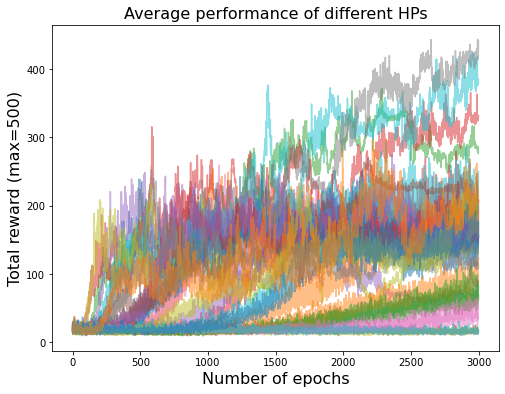

In [8]:
plt.figure(figsize=(8,6))
n_epochs = np.arange(HP_scores.shape[2])
for i in range(len(HP_scores)):
    plt.plot(n_epochs, HP_scores[i].mean(axis=0), alpha=0.5)
plt.title("Average performance of different HPs", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.show()

In [9]:
final_score = HP_asymptotic_score - 3*HP_asymptotic_std # conservative score

In [10]:
best = np.argmax(final_score)

In [11]:
best_HPs = list_of_dict[best]

In [12]:
best_HPs

{'TD': True,
 'twin': True,
 'gamma': 0.99,
 'lr': 0.0026084258104866393,
 'tau': 0.1970007316506616,
 'hiddens': [32, 16]}

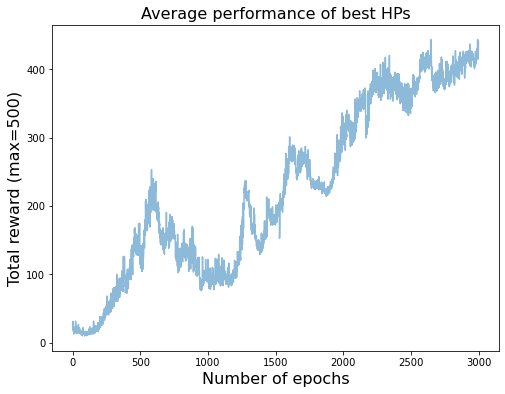

In [13]:
plt.figure(figsize=(8,6))
n_epochs = np.arange(HP_scores.shape[2])
plt.plot(n_epochs, HP_scores[best].mean(axis=0), alpha=0.5)
plt.title("Average performance of best HPs", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.show()

As we can see, after 3000 epochs the average is still increasing, so in the real evaluation we will try with more epochs (e.g. 5000).

But before going on and analyse with those parameters the influence of the twin networks, of the exponential moving average and the temporal difference learning w.r.t. the Monte Carlo one, I'm going to see how the 3 HPs tuned so far influence the performance.

In [14]:
learning_rates = []
taus = []
tot_neurons = []
first_hidden = []

for i in range(len(list_of_dict)):
    learning_rates.append(list_of_dict[i]['lr'])
    taus.append(list_of_dict[i]['tau'])
    tot_n = np.sum(list_of_dict[i]['hiddens'])
    tot_neurons.append(tot_n)
    first = list_of_dict[i]['hiddens'][0]
    first_hidden.append(first)

### Learning rate

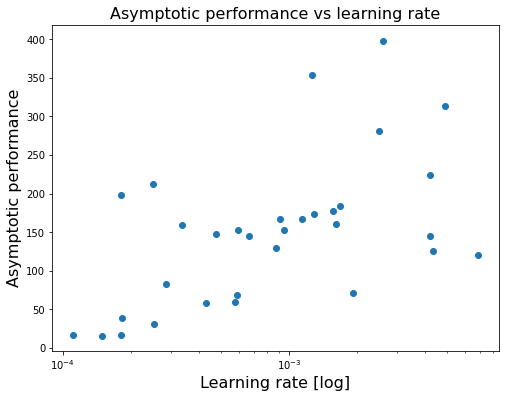

In [15]:
plt.figure(figsize=(8,6))
plt.errorbar(learning_rates, HP_asymptotic_score, yerr= HP_asymptotic_std, fmt='o')
plt.xscale('log')
plt.title("Asymptotic performance vs learning rate", fontsize=16)
plt.xlabel("Learning rate [log]", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

There is a trend showing that higher learning rates on average scored better than lower ones, but also there is a lot of variability due to the other 2 variables that we changed.

### Critic smoothing coefficient (tau)

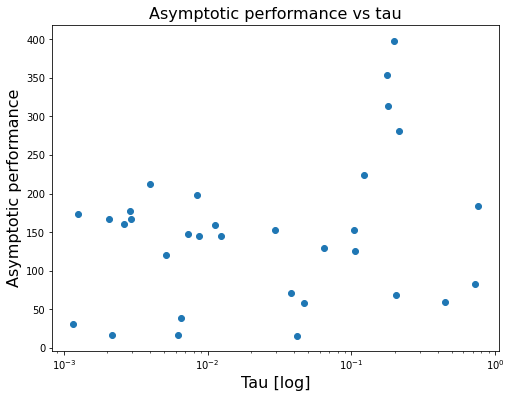

In [16]:
plt.figure(figsize=(8,6))
plt.errorbar(taus, HP_asymptotic_score, yerr= HP_asymptotic_std, fmt='o')
plt.xscale('log')
plt.title("Asymptotic performance vs tau", fontsize=16)
plt.xlabel("Tau [log]", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

Similar to before there seem to be a trend in which higher $\tau$ imply lower performances, but there are some significant outlayers performing much better than any other configuration even though they have very high $\tau$s. This means that there are more fundamental parameters of the model.

### Total number of hidden neurons

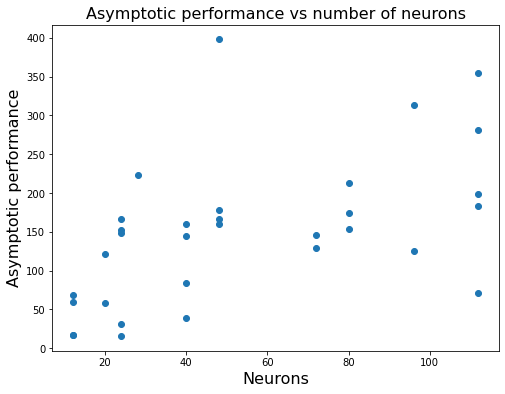

In [17]:
plt.figure(figsize=(8,6))
plt.plot(tot_neurons, HP_asymptotic_score, 'o')
plt.title("Asymptotic performance vs number of neurons", fontsize=16)
plt.xlabel("Neurons", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

The trend here shows that in general greater architectures ([64,32,16]) are better than smaller ([8,4]), thus even the greatest ones are not that great to overfit the problem.

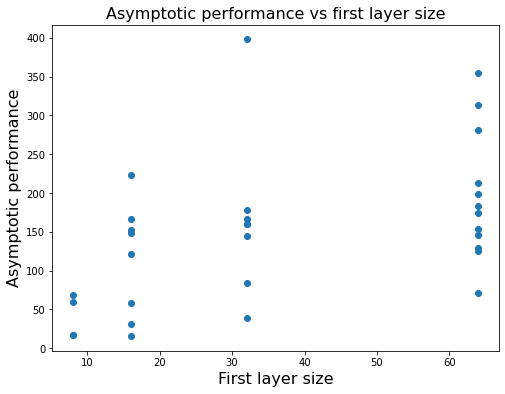

In [18]:
plt.figure(figsize=(8,6))
plt.plot(first_hidden, HP_asymptotic_score, 'o')
plt.title("Asymptotic performance vs first layer size", fontsize=16)
plt.xlabel("First layer size", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

# Part 2 - Evaluating final models

**Models considered:**
* TD or MC
* twin critics or not
* exponential moving average for targets (only in TD case) or not

Thus we have 4 combinations for TD and 2 for MC.

In [19]:
import copy
list_of_models = []

#1: (TD, twin, moving)
list_of_models.append(best_HPs)

#2: (TD, twin, hard)
d = copy.deepcopy(best_HPs)
d['tau'] = 1. 
list_of_models.append(d)

#3: (TD, single, moving)
d = copy.deepcopy(best_HPs)
d['twin'] = False 
list_of_models.append(d)

#4: (TD, single, hard)
d = copy.deepcopy(best_HPs)
d['tau'] = 1. 
d['twin'] = False 
list_of_models.append(d)

#5: (MC, single, hard) 
# tau is not used if TD=False
d = copy.deepcopy(best_HPs)
d['TD'] = False
d['twin'] = False 
list_of_models.append(d)

#6: (MC, twin, hard) 
# tau is not used if TD=False
d = copy.deepcopy(best_HPs)
d['TD'] = False
d['twin'] = True 
list_of_models.append(d)

In [20]:
parent_dir = "Results/No_bootstrapping/"
train = False
if train:
    save = False
    n_runs = 10
    n_episodes = 5000
    HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, list_of_models)

    if save:
        np.save(parent_dir+"model_scores", HP_scores)
        np.save(parent_dir+"model_asymptotic_score", HP_asymptotic_score)
        np.save(parent_dir+"model_asymptotic_std", HP_asymptotic_std)
        np.save(parent_dir+"list_of_models", list_of_models)

In [21]:
HP_scores = np.load(parent_dir+"model_scores.npy")
HP_asymptotic_score = np.load(parent_dir+"model_asymptotic_score.npy")
HP_asymptotic_std = np.load(parent_dir+"model_asymptotic_std.npy")
list_of_dict = np.load(parent_dir+"list_of_models.npy", allow_pickle=True)

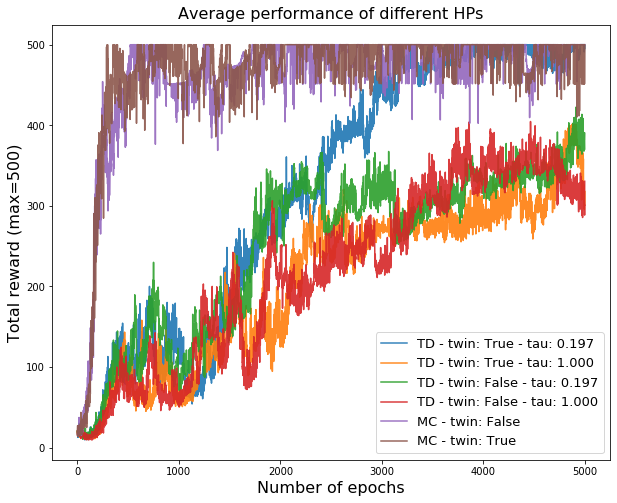

In [22]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores.shape[2])
for i in range(len(HP_scores)):
    if list_of_dict[i]['TD'] == True:
        label = "TD - twin: "+str(list_of_dict[i]['twin'])+" - tau: %.3f"%list_of_dict[i]['tau']
    else:
        label = "MC - twin: "+str(list_of_dict[i]['twin'])
    average = HP_scores[i].mean(axis=0)
    plt.plot(n_epochs, average , alpha=0.9, label=label)
plt.title("Average performance of different HPs", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()

## Final observations

From the last graph it's clear that all the different models benefit from the previous hyper parameters tuning. In particular we can see that MC estimations were superior to TD ones both in sample complexity and stability. For the TD models, the only one that scored almost the maximum possible in every run was the one with both twin critics and target critics updated with exponentially moving average, that had the advantage of being the only model specifically tuned. It's difficult to tell if the two improvements taken separately had a positive impact on the performance, as they don't differ so much from the control version (single critic and target with hard update, i.e. basically no separate target, just detached), but to find out one should run those 3 models for longer, say 10000 episodes per run. 

## Possible developments

1. **Introduce bootstrapping of the terminal states value:** the OpenAI gym environment of Cartpole assigns a reward of +1 to each step and returns a boolean variable `done` that is `True` if the episode is terminated in that step; in that case the value estimated for the last state is just the reward achieved and this is usually expressed as $V(s) = r(s,a) + (1-done) \gamma V(s')$, where True=1, False=0.
The problem is that the environment returns done=True even if the episode is terminated by truncation because the maximum number of steps (500) is reached and so if we treat the two cases in the same way the agent will not learn that achieving 500 is good, but will try to change strategy in order to achieve more. Bootstrapping in this case would basically mean that we set done=False if truncation happens. This is straightforward in the case of TD learning, whereas in the case of MC learning we can't just do that because we rely on the trajectory (that has been truncated) to estimate the values. So in that case we actually want to use the TD estimate for bootstrapping and the value formula could be something like: 
$V(s_t) = \sum_{t'=t}^T \gamma^{t'-t}r(s_{t'},a_{t'}) + \gamma^{T+1-t}(1-done_T)V(s_{T+1})$, where $done_T = 0$ only if the episode is ended by truncation. In this way we account for the discounted rewards that we would do from step T+1 on (V already takes into account disconted rewards, but we have to discount it also because it's a future value and not a present one).

To sum up the target value in the two cases with bootstrapping is computed as:
- Temporal Difference (TD) learning: $V(s) = r(s,a) + (1-done) \gamma V(s')$
- Monte Carlo (MC) learning: $V(s_t) = \sum_{t'=t}^T \gamma^{t'-t}r(s_{t'},a_{t'}) + \gamma^{T+1-t}(1-done_T)V(s_{T+1})$

### Value function with and without bootstrapping

Consider the optimal policy $\pi^*$. For sure it receives a reward of +1 for each step of the episode. Each episode lasts T turns. We want to compute the value function at step t according to the optimal policy in the case of bootstrapping and in the one in which we don't use it.

**With bootstrapping:**

$$V(s_t) \equiv \sum_{t'=0}^{\infty}\gamma^{t'} = \frac{1}{1-\gamma} \equiv V^*$$

where I use the infinite geometric series. <br>

This can be decomposed in two pieces

$$V(s_t) = \sum_{t'=0}^{T-t}\gamma^{t'} + \gamma^{T-t+1}V(s_{T+1}) =  \frac{1-\gamma^{T-t+1}}{1-\gamma} + \frac{\gamma^{T-t+1}}{1-\gamma}$$

where I use the truncated geometric series $\sum_{k=0}^{n-1}r = \frac{1-r^n}{1-r}$ and $V(s_{T+1}) = \frac{1}{1-\gamma}$, because since the episode should be infinite, each state has this same value.

**Without bootstrapping:**
$$V(s_t) = \sum_{t'=0}^{T-t}\gamma^{t'} = \frac{1-\gamma^{T-t+1}}{1-\gamma} = V^* - \Delta V(s_t)$$

where $\Delta V(s_t) = \frac{\gamma^{T-t+1}}{1-\gamma}$. So basically $\Delta V(s_t)$ is the error from truncation that we commit not taking into account bootstrapping and is an increasing function of $t$ since $\gamma < 1$. But aside from that, if we think that the objective of the learner is to arrive at step T, the value function is well-behaved and as expected its value is 1 for terminal states (since we count just the final reward of +1) and less for all the others.

## Part 3 - Testing bootstrapping

In [19]:
import HP_tuning as hp
import numpy as np
import matplotlib.pyplot as plt
import torch
from importlib import reload

import gym
import ActorCritic

In [20]:
reload(hp)
reload(ActorCritic)

<module 'ActorCritic' from '/m/home/home9/94/dainesn1/unix/Workdir/Policy-based-RL/ActorCritic.py'>

In [21]:
list_of_dict = np.load("Results/No_bootstrapping/list_of_models.npy", allow_pickle=True)

In [22]:
list_HPs_pt1 = list_of_dict[:3]
list_HPs_pt1

array([{'TD': True, 'twin': True, 'gamma': 0.99, 'lr': 0.0026084258104866393, 'tau': 0.1970007316506616, 'hiddens': [32, 16]},
       {'TD': True, 'twin': True, 'gamma': 0.99, 'lr': 0.0026084258104866393, 'tau': 1.0, 'hiddens': [32, 16]},
       {'TD': True, 'twin': False, 'gamma': 0.99, 'lr': 0.0026084258104866393, 'tau': 0.1970007316506616, 'hiddens': [32, 16]}],
      dtype=object)

In [23]:
parent_dir = "Results/Bootstrapping/"
train = False
if train:
    save = False
    n_runs = 10
    n_episodes = 5000
    HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, list_HPs_pt1, 
                                                                     shape_r=False, bootstrap_flag=True)

    if save:
        
        np.save(parent_dir+"model_scores_boots_pt1", HP_scores)
        np.save(parent_dir+"model_asymptotic_score_boots_pt1", HP_asymptotic_score)
        np.save(parent_dir+"model_asymptotic_std_boots_pt1", HP_asymptotic_std)
        np.save(parent_dir+"list_of_models_boots_pt1", list_HPs_pt1)

In [24]:
HP_scores_b = np.load(parent_dir+"model_scores_boots.npy")
HP_asymptotic_score_b = np.load(parent_dir+"model_asymptotic_score_boots.npy")
HP_asymptotic_std_b = np.load(parent_dir+"model_asymptotic_std_boots.npy")
list_of_dict_b = np.load(parent_dir+"list_of_models_boots.npy", allow_pickle=True)

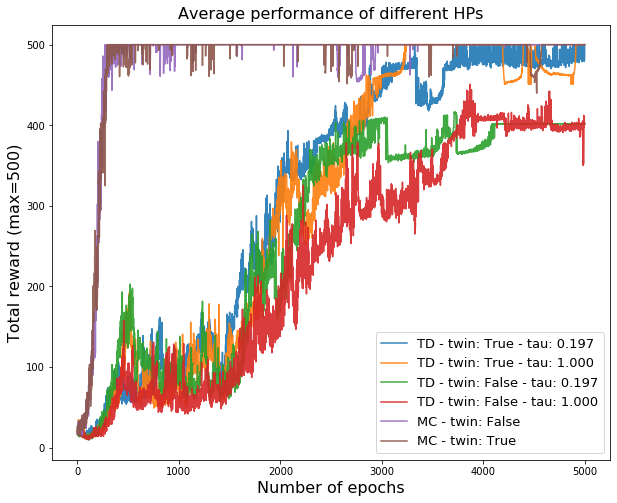

In [29]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores_b.shape[2])
for i in range(len(HP_scores_b)):
    if list_of_dict_b[i]['TD'] == True:
        label = "TD - twin: "+str(list_of_dict_b[i]['twin'])+" - tau: %.3f"%list_of_dict_b[i]['tau']
    else:
        label = "MC - twin: "+str(list_of_dict_b[i]['twin'])
    average = HP_scores_b[i].mean(axis=0)
    plt.plot(n_epochs, average, alpha=0.9, label=label)
plt.title("Average performance of different HPs", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()

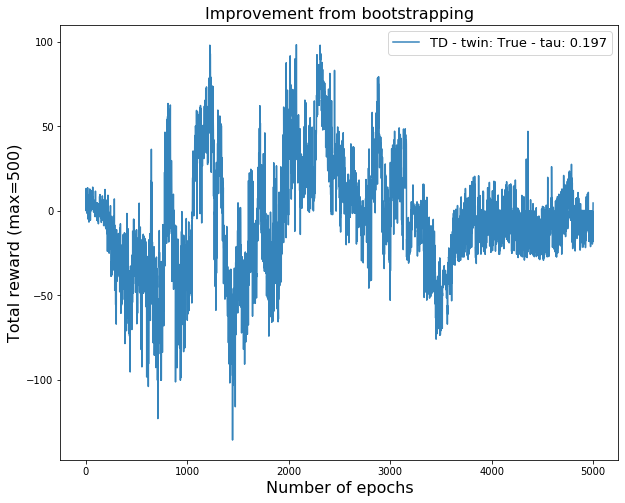

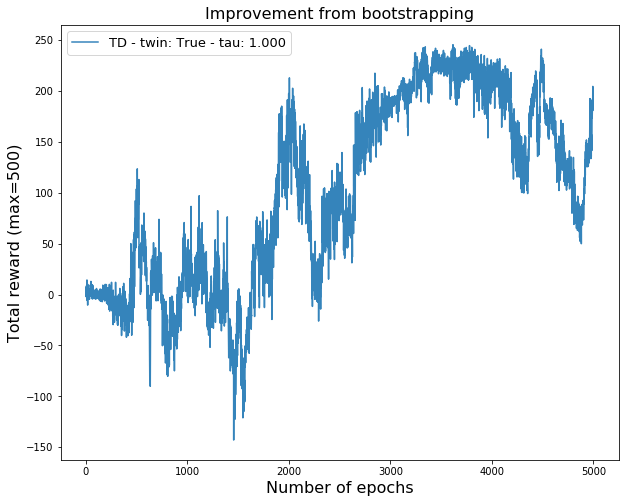

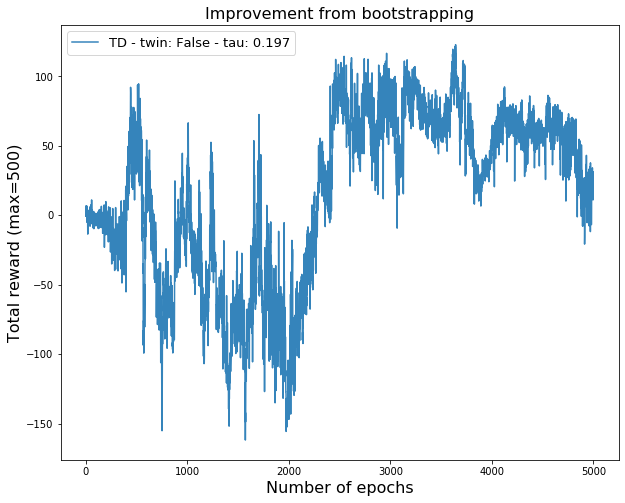

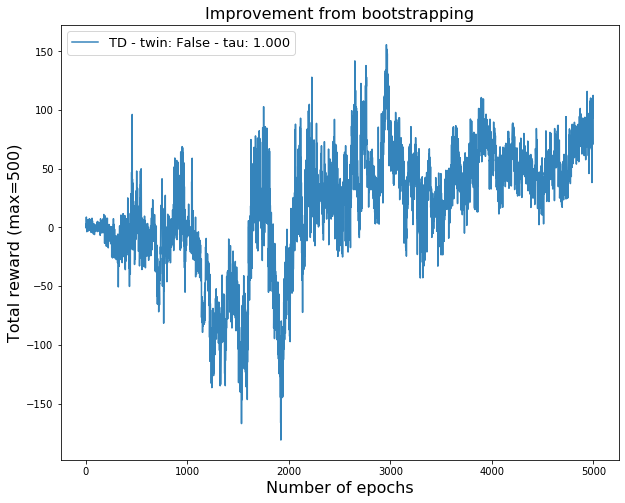

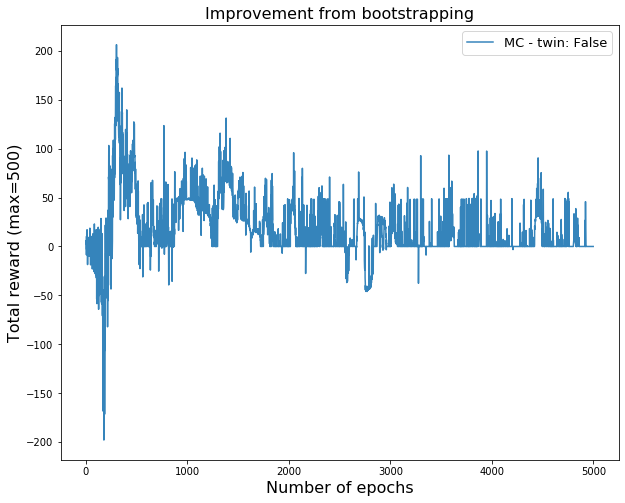

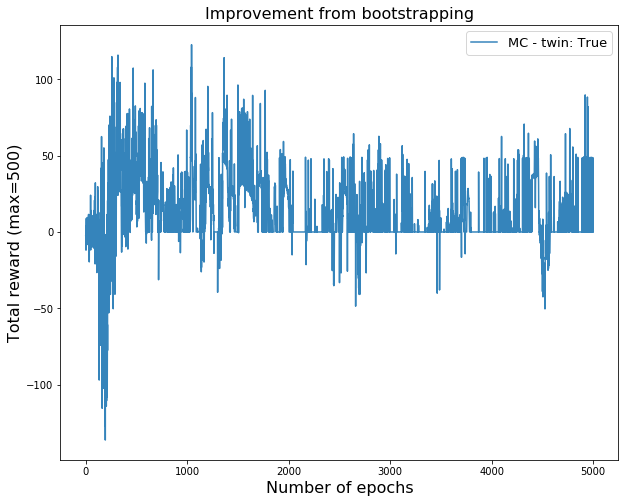

In [30]:
# please load params from part 2
n_epochs = np.arange(HP_scores_b.shape[2])
for i in range(len(HP_scores_b)):
    if list_of_dict_b[i]['TD'] == True:
        label = "TD - twin: "+str(list_of_dict_b[i]['twin'])+" - tau: %.3f"%list_of_dict_b[i]['tau']
    else:
        label = "MC - twin: "+str(list_of_dict_b[i]['twin'])
    average_boot = HP_scores_b[i].mean(axis=0)
    average_old = HP_scores[i].mean(axis=0)
    diff = average_boot - average_old
    plt.figure(figsize=(10,8))
    plt.plot(n_epochs, diff, alpha=0.9, label=label)
    plt.title("Improvement from bootstrapping", fontsize=16)
    plt.xlabel("Number of epochs", fontsize=16)
    plt.ylabel("Total reward (max=500)", fontsize=16)
    plt.legend(fontsize = 13)                                                        
    plt.show()

# Part 4 - n-steps TD learning

In [31]:
import HP_tuning as hp
import numpy as np
import matplotlib.pyplot as plt
import torch
from importlib import reload

import gym
import ActorCritic

In [32]:
reload(ActorCritic)
reload(hp)

<module 'HP_tuning' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/HP_tuning.py'>

In [33]:
list_of_dict = np.load("Results/No_bootstrapping/list_of_models.npy", allow_pickle=True)

In [34]:
n_step_TD_models = []
n_steps = [5,10,20,50]
for n in n_steps:
    d = dict(n_steps=n, **list_of_dict[0])
    n_step_TD_models.append(d)

In [35]:
n_step_TD_models

[{'n_steps': 5,
  'TD': True,
  'twin': True,
  'gamma': 0.99,
  'lr': 0.0026084258104866393,
  'tau': 0.1970007316506616,
  'hiddens': [32, 16]},
 {'n_steps': 10,
  'TD': True,
  'twin': True,
  'gamma': 0.99,
  'lr': 0.0026084258104866393,
  'tau': 0.1970007316506616,
  'hiddens': [32, 16]},
 {'n_steps': 20,
  'TD': True,
  'twin': True,
  'gamma': 0.99,
  'lr': 0.0026084258104866393,
  'tau': 0.1970007316506616,
  'hiddens': [32, 16]},
 {'n_steps': 50,
  'TD': True,
  'twin': True,
  'gamma': 0.99,
  'lr': 0.0026084258104866393,
  'tau': 0.1970007316506616,
  'hiddens': [32, 16]}]

In [36]:
train = False
parent_dir = "Results/n_steps/"
if train:
    save = False
    n_runs = 10
    n_episodes = 5000
    HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, n_step_TD_models[:2], 
                                                                     shape_r=False, bootstrap_flag=True)

    if save:
        
        np.save(parent_dir+"/model_scores_n_steps_pt1", HP_scores)
        np.save(parent_dir+"/model_asymptotic_score_n_steps_pt1", HP_asymptotic_score)
        np.save(parent_dir+"/model_asymptotic_std_n_steps_pt1", HP_asymptotic_std)
        np.save(parent_dir+"/list_of_models_boots_n_steps_pt1", n_step_TD_models[:2])

Compare:
- TD methods with different n_steps
- best TD vs MC methods

In [37]:
HP_scores_n = np.load(parent_dir+"model_scores_n_steps.npy")
HP_asymptotic_score_n = np.load(parent_dir+"model_asymptotic_score_n_steps.npy")
HP_asymptotic_std_n = np.load(parent_dir+"model_asymptotic_std_n_steps.npy")
list_of_dict_n = np.load(parent_dir+"list_of_models_n_steps.npy", allow_pickle=True)

In [38]:
list_of_dict_n[-1]

{'n_steps': 50,
 'TD': True,
 'twin': True,
 'gamma': 0.99,
 'lr': 0.0026084258104866393,
 'tau': 0.1970007316506616,
 'hiddens': [32, 16]}

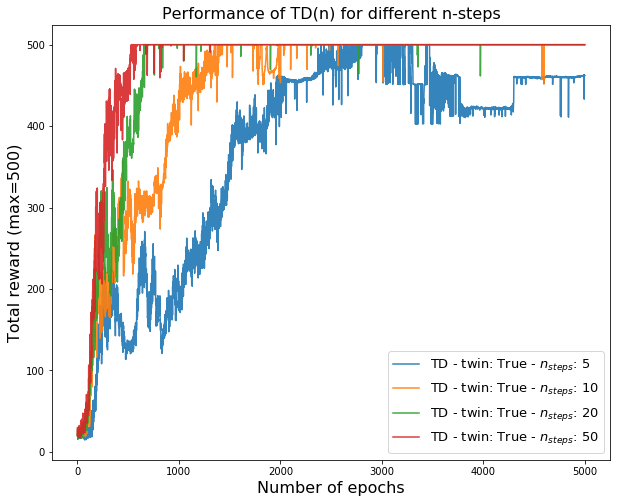

In [39]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores_n.shape[2])
for i in range(len(HP_scores_n)):
    label = "TD - twin: "+str(list_of_dict_n[i]['twin'])+r" - $n_{steps}$: %d"%list_of_dict_n[i]['n_steps']
    average = HP_scores_n[i].mean(axis=0)
    plt.plot(n_epochs, average, alpha=0.9, label=label)
plt.title("Performance of TD(n) for different n-steps", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()

**Observation:** from the graph above we can see that increasing the number of steps in the TD method increases both its performance and its sample efficiency (less episodes needed to learn). 

In [40]:
# please load params from pat 3
list_of_dict_b[-1]

{'TD': False,
 'twin': True,
 'gamma': 0.99,
 'lr': 0.0026084258104866393,
 'tau': 0.1970007316506616,
 'hiddens': [32, 16]}

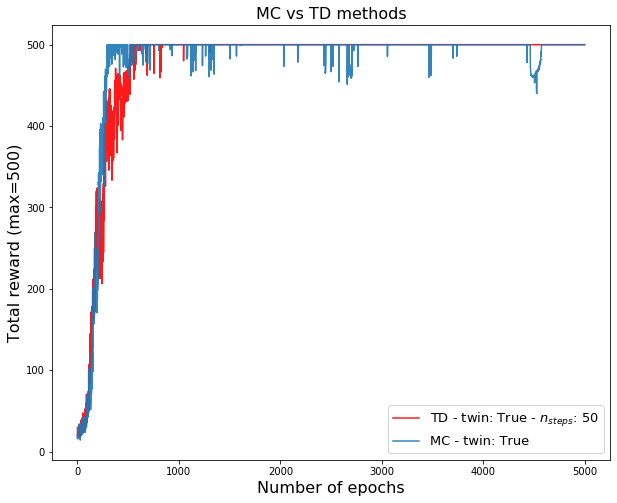

In [41]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores_n.shape[2])

label_TD = "TD - twin: "+str(list_of_dict_n[-1]['twin'])+r" - $n_{steps}$: %d"%list_of_dict_n[-1]['n_steps']
plt.plot(n_epochs, HP_scores_n[-1].mean(axis=0), 'r', alpha=0.9, label=label_TD)

label_MC = "MC - twin: "+str(list_of_dict_b[-1]['twin'])
plt.plot(n_epochs, HP_scores_b[-1].mean(axis=0), alpha=0.9, label=label_MC)

plt.title("MC vs TD methods", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()

**Observation:** finally with a good number of n steps we get to an even comparison between the two methods, with the MC estimation that still seems slightly more efficient in learning but less stable asymptotically.